In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import train
import models
import metrics as m

In [2]:
train.set_seed(0)

In [3]:
data_folder = 'data'

# Download datset and get mean and standard deviation
train_data = datasets.MNIST(root = data_folder, 
                            train = True, 
                            download = True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13064366579055786
Calculated std: 0.30810779333114624


In [4]:
# Transformations
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

# Apply transformations to data
train_data = datasets.MNIST(root = data_folder, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = data_folder, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [5]:
# Get validation data from train set
train_percentage = 0.9

n_train_examples = int(len(train_data) * train_percentage)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
    )

# Copy validation data and apply test transformations (without data augmentation)
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


Data labels: [9, 3, 5, 4, 7, 4, 9, 6, 8, 8, 7, 4, 8, 9, 4, 0, 6, 8, 9, 9, 3, 1, 3, 2, 5]


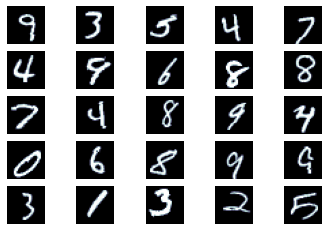

In [7]:
# See data
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

n_images = 25

images = []
labels = []

for image, label in [train_data[i] for i in range(n_images)]:
    images.append(image)
    labels.append(label)

print('Data labels: ' + str(labels))
plot_images(images)

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = BATCH_SIZE
    )

validation_loader = DataLoader(
    valid_data,
    batch_size = BATCH_SIZE
    )

test_loader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE
    )


In [9]:
# Device GPU/CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [10]:
model = models.LeNet()
print(model)

if(device.type == 'cuda'):
    model.to(device)

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout2d(p=0.5, inplace=False)
    (7): Flatten()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [11]:
lr = 0.001
epochs = 15

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)
model, metrics = train.train(
    model,
    train_loader,
    validation_loader,
    optimizer,
    criterion,
    device,
    epochs,
    BATCH_SIZE,
    lr, 
    net_class='cnn',
    one_hot=True
    )

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout2d(p=0.5, inplace=False)
    (7): Flatten()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)
Number of trainable parameters: 34622
Starting trainig...
Epoch 1......Step: 562/1688....... Average Loss, Accuracy for Step: 0.7401, 0.7682
Epoch 1......Step: 1124/1688....... Average Loss, Accuracy for Step: 0.5712, 0.8241
Epoch 1......Step: 1686/1688....... Average Loss, Accuracy for Step: 0.4916, 0.8492

Epoch 1/15 Done.
	 Tain Loss: 0.4915307664546356  Validation Loss: 0.1116922597321582

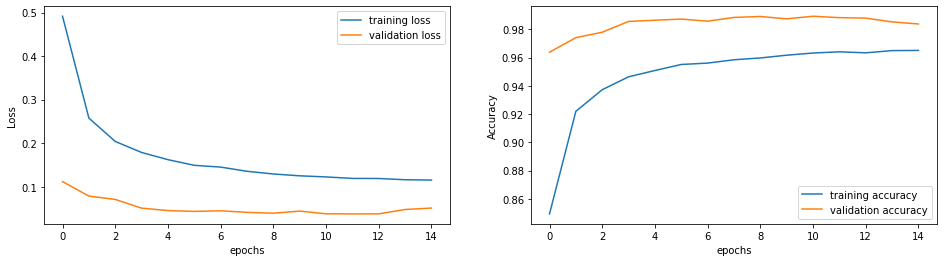

In [12]:
# Print metrics
train.plot_train_metrics(metrics)

In [19]:

# Test model
test_labels, test_predictions, test_metrics = train.test_model(
    model,
    test_loader,
    criterion,
    device,
    BATCH_SIZE,
    net_class='cnn',
    one_hot=True
)


print('Test loss: ' + str(test_metrics[0]))
print('Test accuracy: ' + str(test_metrics[1]))

Test loss: 0.04382417544361967
Test accuracy: 0.987


Metrics for 0.6 threshold


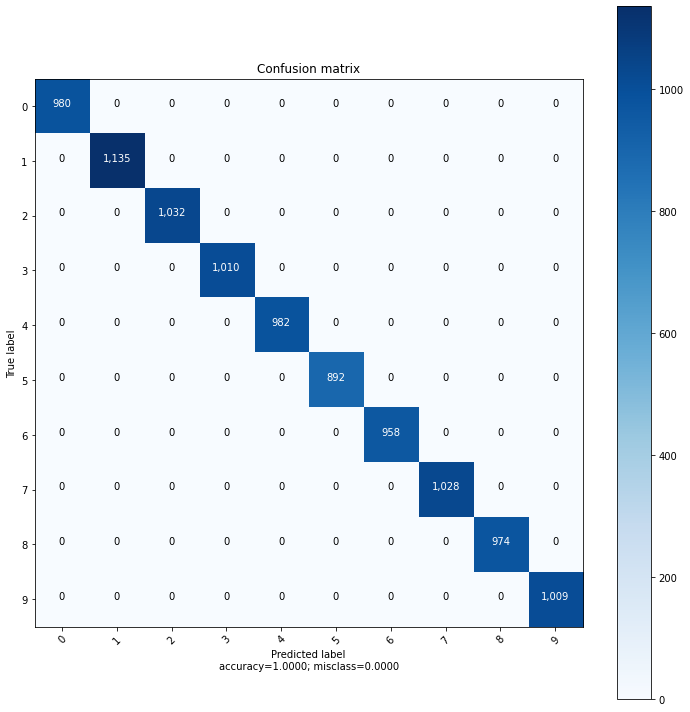

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

_____________________________________



In [31]:

target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


result = m.get_metrics(test_labels, test_predictions)
print('Metrics for {0} threshold'.format(threshold))
m.plot_confusion_matrix(
    result[1],
    target_names,
    normalize=False
)
print(result[0])
print('_____________________________________')
print('')

In [35]:
model_name = 'models/LeNet_' + str(int(time.time()))

model.save(
    model_name,
    metrics,
    lr,
    epochs,
    BATCH_SIZE,
    criterion,
    optimizer
)

model.save_scripted(model_name)
print('Model saved as: ' + model_name)

Model saved as: models/LeNet_1602349566
